## Training and predicting objects using Mask RCNN model

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Host pretrained model](#Host-pretrained-model)
4. [Train model](#Train-model)

## Introduction

placeholder

## Setup

Before preparing the data, there are some initial steps required for setup. To train the image classification algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. Here we will use the execution role the current notebook instance was given when it was created.  This role has necessary permissions, including access to your data in S3.

In [1]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::480604769687:role/service-role/AmazonSageMaker-ExecutionRole-20190530T172586


We also need to identify the S3 bucket that you want to use for providing training and validation datasets. It will be used to store the tranied model artifacts as well. In this notebook, we use a default bucket for use with SageMaker in your account. Alternatively, you could use whatever bucket you would like. We use an object prefix to help organize the bucket content.

In [2]:
bucket = sess.default_bucket() # or use your own custom bucket name
prefix = 'DEMO-RCNN-model'

**Important.** Refine and define parameters of your training and inference.

In [11]:
IS_LOCAL = True # defines whether training is done on notebook instance (i.e. IS_LOCAL=TRUE) or on remote Sagemaker nodes (IS_LOCAL=FALSE)
WORK_DIR = "/home/ec2-user/SageMaker/object-detection" # TODO: make it soft-coded, e.g. via os.path.abspath("../")
COCO_MODEL_PATH = WORK_DIR+"/mask_rcnn_coco.h5"
IMAGE_DIR = WORK_DIR+"/Mask_RCNN/images"

if IS_LOCAL: # create directory to store model output when training/infering lcoally.
    MODEL_DIR = "model"
    ! mkdir -p {WORK_DIR}/{MODEL_DIR}

## Install Dependencies

To be able to run pre-trained MRCNN model, we need to resolve several dependencies:
- install number of Python packages;
- build MRCNN package from source;
- copy model weights trained on MS COCO dataset.

Review setup.sh and requirements.txt for details.

In [ ]:
! pygmentize code/setup.sh

In [ ]:
! pygmentize code/requirements.txt

In [ ]:
if IS_LOCAL: # if training on notebook instance, ensure that all dependecies are deployed.
    ! pip install -r {WORK_DIR}/code/requirements.txt
    ! sudo sh {WORK_DIR}/code/setup.sh {WORK_DIR}

## Inference of pre-trained model

In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
#sys.path.append("/home/ec2-user/SageMaker/object-detection/Mask_RCNN/samples/coco/")  # To find local version
#import coco
from Mask_RCNN.samples.coco import coco

%matplotlib inline 

Using TensorFlow backend.


In [7]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [8]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

W0919 19:59:54.180625 140040004581184 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0919 19:59:54.207249 140040004581184 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0919 19:59:54.213690 140040004581184 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0919 19:59:54.238433 140040004581184 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:19

In [9]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


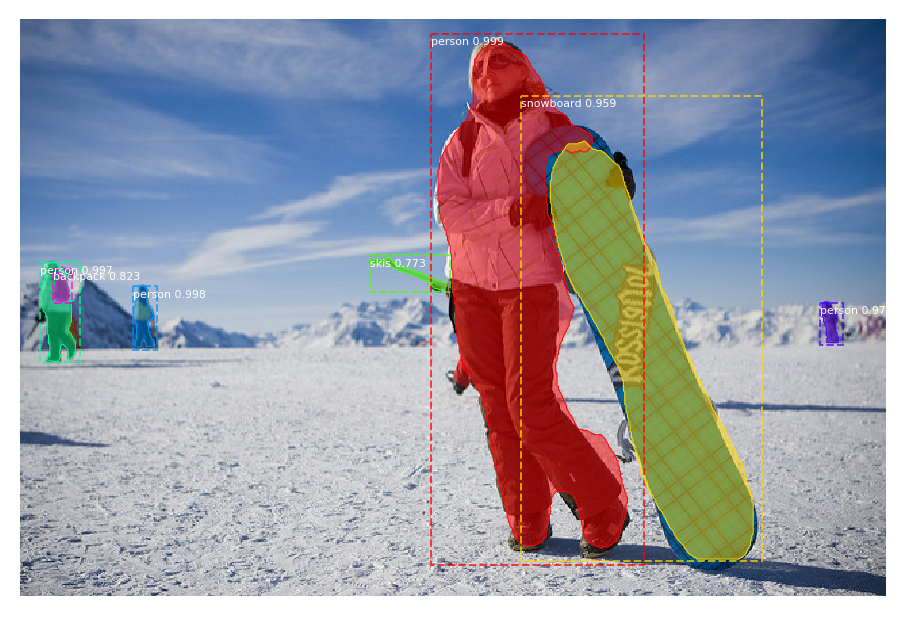

In [13]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])